In [1]:
import pandas as pd # data analysis/wrangling
import numpy as np # math if required

from scipy import stats # stat tests
from statsmodels.graphics.gofplots import qqplot ## qq plots to assess normality

import matplotlib.pyplot as plt # visuals
import seaborn as sns # visuals

In [2]:
#import data
data = pd.read_csv('/home/sbangarh/AB_cookie_cats/cookie_cats.csv')
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# Data Overview

In [8]:
#get info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [9]:
#check for nulls
data.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [10]:
#check for duplicates
data.duplicated().sum()

0

No duplicates or nulls :)

# Exploratory data analysis

In [3]:
#convert userid to str - won't interfre wtih numeric analysis
data['userid'] = data['userid'].astype(str)

#change retention_1 and retention_7 to 0/1 boolean
bool_dict = {True: 1, False: 0}
data[['retention_1', 'retention_7']] = data[['retention_1', 'retention_7']].map(bool_dict.get)

#check work
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  object
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.4+ MB


In [17]:
#summary stats
data.describe()

,sum_gamerounds,retention_1,retention_7
count,90189.000000,90189.000000,90189.000000
mean,51.872457,0.445210,0.186065
std,195.050858,0.496992,0.389161
min,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000
50%,16.000000,0.000000,0.000000
75%,51.000000,1.000000,0.000000
max,49854.000000,1.000000,1.000000


In [18]:
#summary stats for categorical data
data.describe(include='O')

,userid,version
count,90189,90189
unique,90189,2
top,116,gate_40
freq,1,45489


In [5]:
#describe by gate versions
summary_30 = data[data['version'] == 'gate_30']['sum_gamerounds'].describe()
summary_40 = data[data['version'] == 'gate_40']['sum_gamerounds'].describe()

print(f"Gate 30:\n{summary_30}")
print(f"Gate 40:\n{summary_40}")

Gate 30:
count    44700.000000
mean        52.456264
std        256.716423
min          0.000000
25%          5.000000
50%         17.000000
75%         50.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64
Gate 40:
count    45489.000000
mean        51.298776
std        103.294416
min          0.000000
25%          5.000000
50%         16.000000
75%         52.000000
max       2640.000000
Name: sum_gamerounds, dtype: float64


Let's explore some visuals

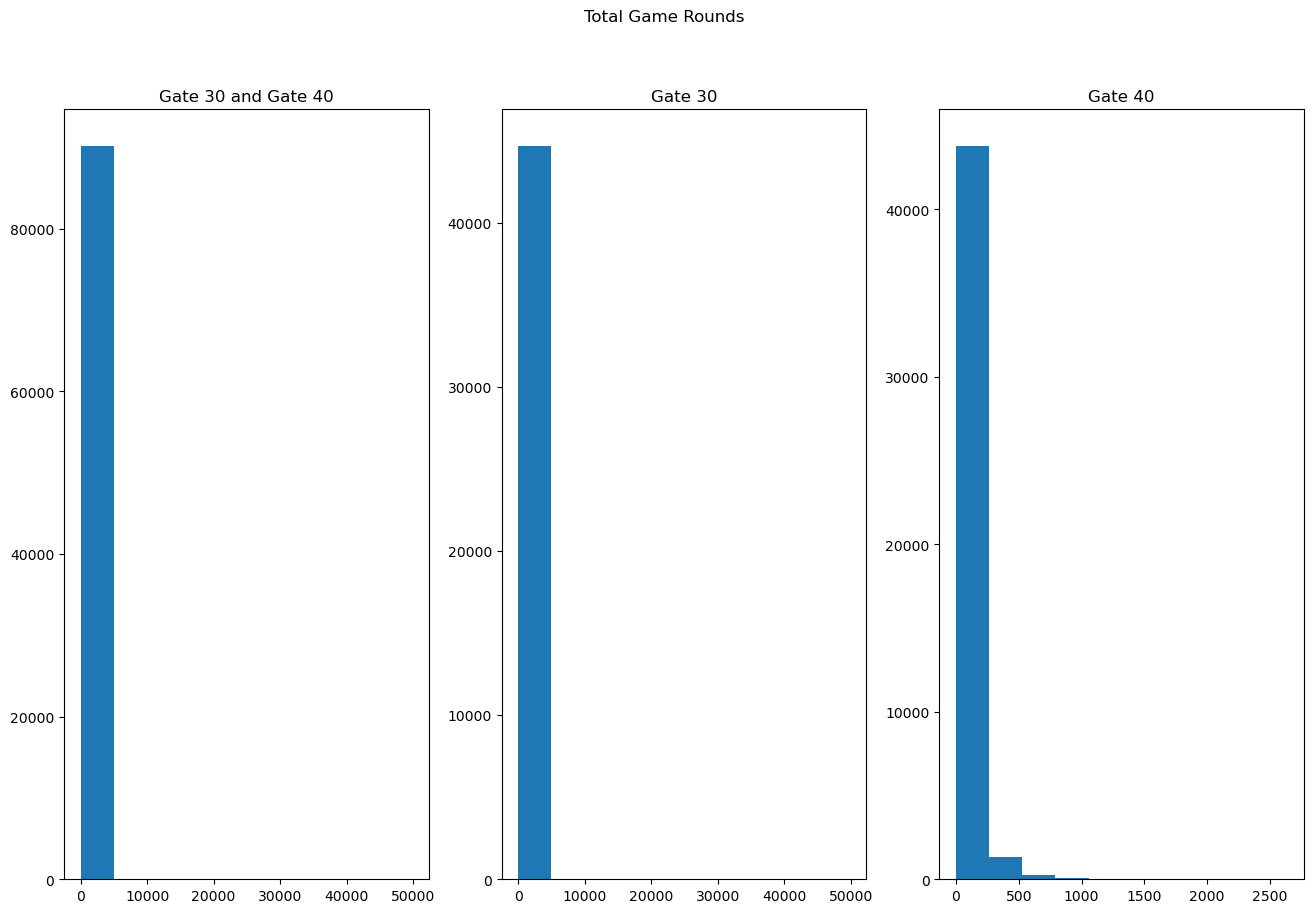

In [6]:
#data for specific versions
gate_30 = data[data['version'] == 'gate_30']
gate_40 = data[data['version'] == 'gate_40']

#make subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 10))

#plot histograms on subplots
axs[0].hist(data['sum_gamerounds'])
axs[0].set_title('Gate 30 and Gate 40')

axs[1].hist(gate_30['sum_gamerounds'])
axs[1].set_title('Gate 30')

axs[2].hist(gate_40['sum_gamerounds'])
axs[2].set_title('Gate 40')

fig.suptitle('Total Game Rounds')
plt.show()



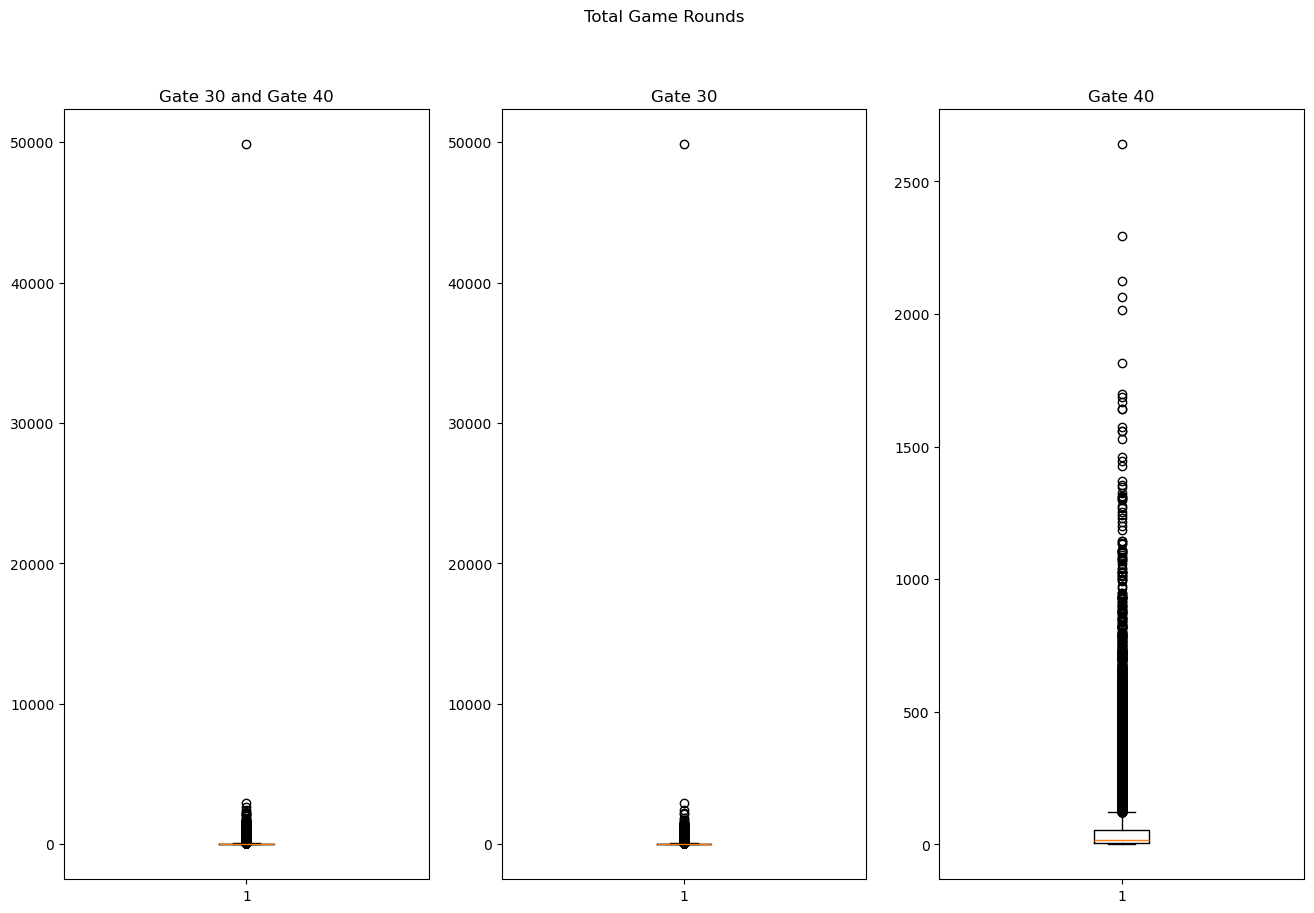

In [7]:
#make subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 10))

#plot histograms on subplots
axs[0].boxplot(data['sum_gamerounds'])
axs[0].set_title('Gate 30 and Gate 40')

axs[1].boxplot(gate_30['sum_gamerounds'])
axs[1].set_title('Gate 30')

axs[2].boxplot(gate_40['sum_gamerounds'])
axs[2].set_title('Gate 40')

fig.suptitle('Total Game Rounds')
plt.show()

- gamerounds will need to be binned or transformed (log most likely) regardless of version
- Gate 30 also has higher range and spread than Gate 40


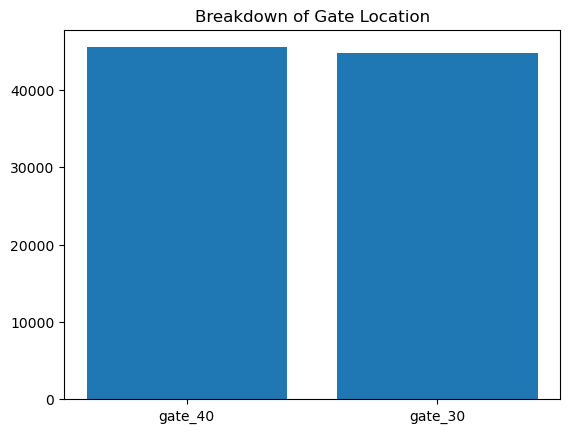

In [11]:
#breakdown of gate version counts to see size comparison
gate_counts = data['version'].value_counts()

#plt bar
plt.bar(gate_counts.index, gate_counts.values)
plt.title('Breakdown of Gate Location')
plt.show()

- The number of instances is approximately equal for both versions
- We should look at instances where sum_gamerounds = 0, but retention for both periods are True - might want to remove as they could be bots and not actual players.

In [7]:
#want to look at instances where sum_gameround is 0, but retention is true. These could be bots or non-active participants who should not be considered.
bots = data[(data['sum_gamerounds'] == 0) & ((data['retention_1'] == 1) | (data['retention_7'] == 1))]
bots.groupby('version').count()
# 111 potential bots with an approximate equal amount among versions

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,56,56,56,56
gate_40,55,55,55,55


In [5]:
# make mask to filter
my_bots = (data['sum_gamerounds'] == 0) & ((data['retention_1'] == 1) | (data['retention_7'] == 1))

In [6]:
# make copy of data and remove bots and use the bot-less data going forward
copy = data.copy()
#drop bots
copy = copy[~my_bots]
copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90078 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90078 non-null  object
 1   version         90078 non-null  object
 2   sum_gamerounds  90078 non-null  int64 
 3   retention_1     90078 non-null  int64 
 4   retention_7     90078 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.1+ MB


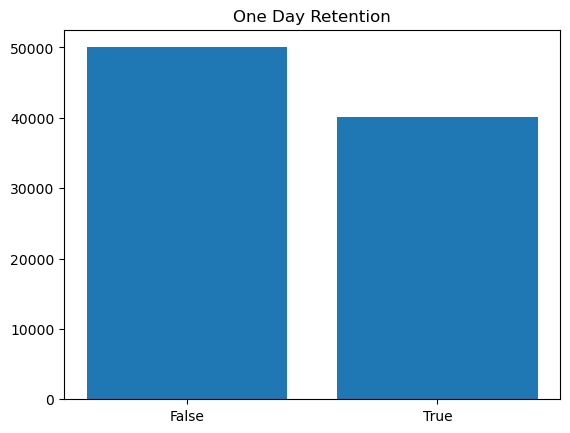

In [21]:
# get total counts for one day retention
retention_1_counts = copy['retention_1'].value_counts()

#plot counts
plt.bar(retention_1_counts.index, retention_1_counts.values)
plt.title('One Day Retention')
plt.xticks([0, 1], ['False', 'True'])
plt.show()

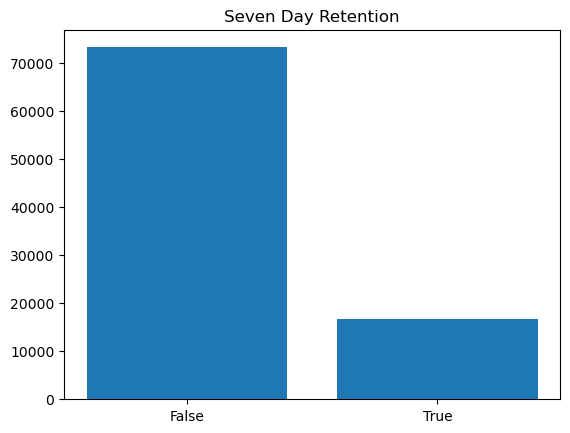

In [22]:
# get total counts for seven day retention
retention_7_counts = copy['retention_7'].value_counts()

#plot counts
plt.bar(retention_7_counts.index, retention_7_counts.values)
plt.title('Seven Day Retention')
plt.xticks([0, 1], ['False', 'True'])
plt.show()

- Regardless of version, players tend not to sign in/play one day after downloading. This observation is much more significant in magnitude when it comes to seven day retention.

Explore bivariate relations

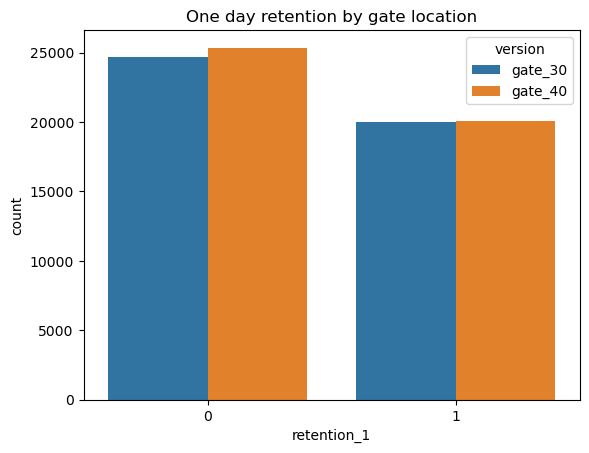

In [23]:
#retention count by gate
sns.countplot(data=copy, x='retention_1', hue='version')
plt.title('One day retention by gate location')
plt.show()

Gate_40 appears to have a higher false retention count than gate_30 for one day retention. There appears to be minimal difference in True one day retention, although gate_40 appears slightly ahead.

let's look at the retention rate

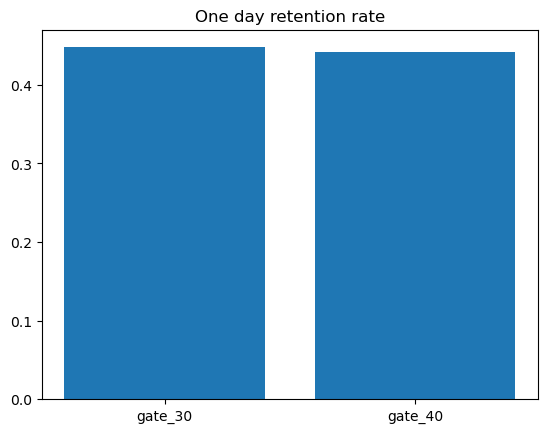

In [24]:
#get one day retention rate
one_day_rates = copy.groupby('version')['retention_1'].mean()

#plot one day rates
plt.bar(one_day_rates.index, one_day_rates.values)
plt.title('One day retention rate')
plt.show()

The one day retention rate appears almost identical, but will have to assess if it is statistically significant

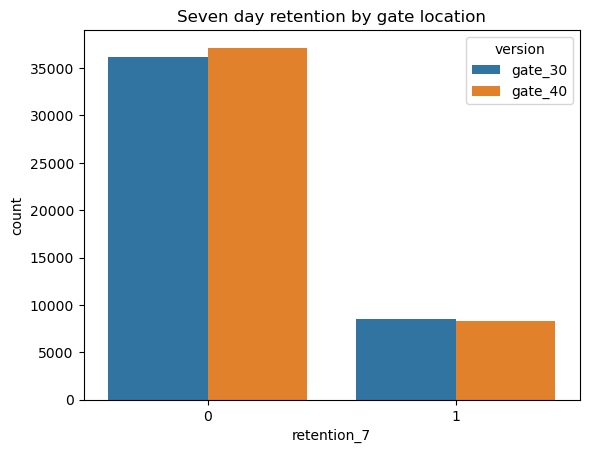

In [25]:
#retention by gate
sns.countplot(data=copy, x='retention_7', hue='version')
plt.title('Seven day retention by gate location')
plt.show()

The drop off for seven days is significant for both gates. The gate_30 version appears to be higher for total count indicating that an earlier gate is better at retaining players over long-term.

Let's look at retention rate too just to confirm

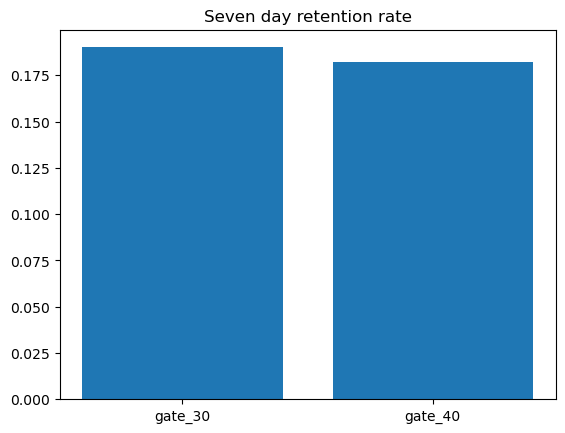

In [26]:
#get seven day retention rates
seven_day_rates = copy.groupby('version')['retention_7'].mean()

#plot
plt.bar(seven_day_rates.index, seven_day_rates.values)
plt.title('Seven day retention rate')
plt.show()

- There appears to be a more identifiable gap for a seven day retention than the one day retention rate. 

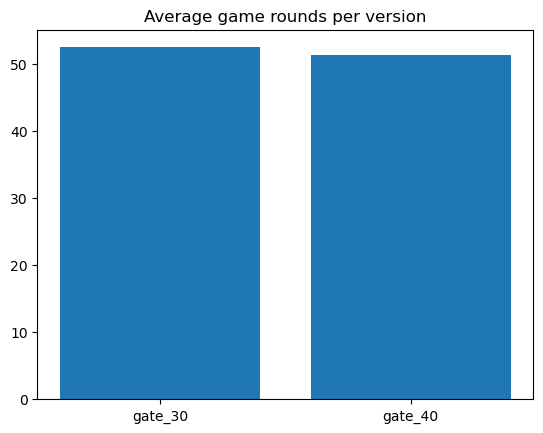

In [32]:
#avg game rounds per group
game_round_mean = copy.groupby('version')['sum_gamerounds'].mean()

#plot
plt.bar(game_round_mean.index, game_round_mean.values)
plt.title('Average game rounds per version')
plt.show()

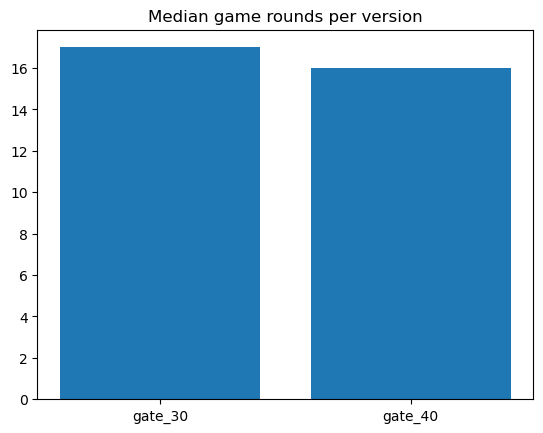

In [31]:
#avg game rounds per group
game_round_median = copy.groupby('version')['sum_gamerounds'].median()

#plot
plt.bar(game_round_median.index, game_round_median.values)
plt.title('Median game rounds per version')
plt.show()

- The average game rounds appear almost identical between the version
- The median game rounds is still close, but the difference is more apparent

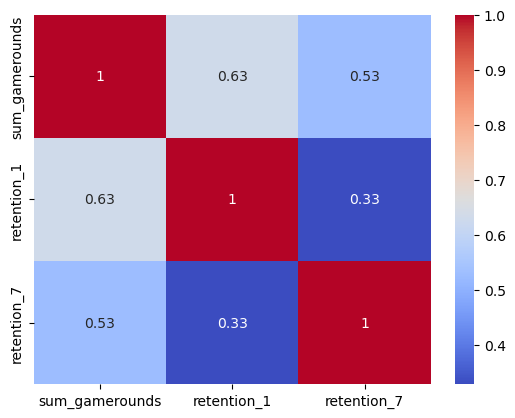

In [29]:

#get correlation and heatmap
corr = copy[['sum_gamerounds', 'retention_1', 'retention_7']].corr('spearman') #use spearman because data not normal
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

game rounds are correlated with both retention metrics. Both retentions are mildly correlated with each other.

## Exploration of sum_gamerounds

Want to explore log transform and binning for parametric tests when time

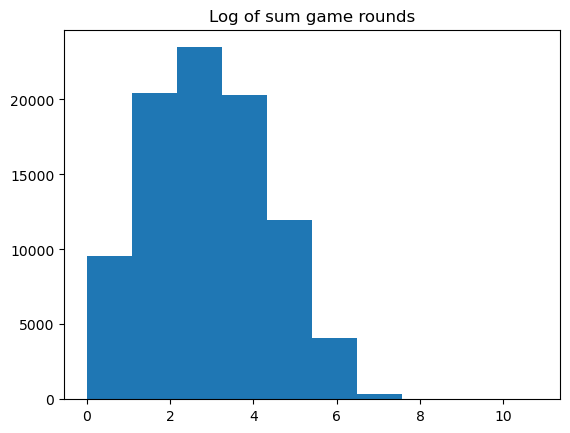

In [4]:
#log transform
game_rounds = data.loc[:, 'sum_gamerounds']

game_rounds = np.log1p(game_rounds)

plt.hist(game_rounds)
plt.title('Log of sum game rounds')
plt.show()

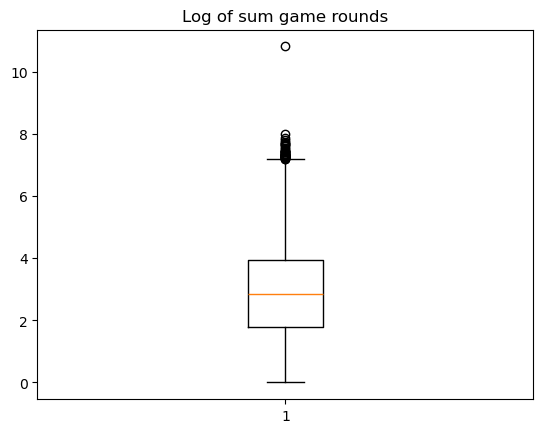

In [5]:
#boxplot of game rounds
plt.boxplot(game_rounds)
plt.title('Log of sum game rounds')
plt.show()

Data is skewed and there are outliers present...Could winsorize or remove. 

come back to explore. Let's make some hypotheses and perform statisitcal tests

# Hypotheses:
Will explore non-parametric first, then parametric to see if anything changes.

## Sum Game rounds
- H0: There is no difference between the average sum game rounds for the gate_30 and gate_40 versions
- Ha: There is a difference between the average sum game rounds for the gate_30 and gate_40 versions
- test to use: Mann-Whitney U

## Sum game rounds and retention rates
- H0: There is no difference between the average games played and the retention rates for the respecitve versions
- Ha: There is a difference between the average games played and the retention rates for the respecitve versions
- test: Z-test

## retention_1
- H0: There is no difference between the gate_30 and gate_40 versions and the number of users who log on one day after downloading
- Ha: There is a difference between the gate_30 and gate_40 versions and the number of users who log on one day after downloading
- Test: Chi-Square

## retention_2
- H0: There is no difference between the gate_30 and gate_40 versions and the number of users who log on seven day after downloading
- Ha: There is a difference between the gate_30 and gate_40 versions and the number of users who log on seven day after downloading
- Test: Chi-square

Maybe add in logistic regression as well?

In [30]:
# declare variables
gate_30 = copy[copy['version'] == 'gate_30']['sum_gamerounds'].values
gate_40 = copy[copy['version'] == 'gate_40']['sum_gamerounds'].values

#perform Mann-Whitney
stat, pvalue = stats.mannwhitneyu(gate_30, gate_40)

if pvalue < 0.05:
    print("Reject Null: There is difference between the average game rounds for the two versions")
else:
    print("Fail to reject Null: There is no difference between the two versions for average game rounds played")

Reject Null: There is difference between the average game rounds for the two versions


In [33]:
#chi-square for the versions and one day retention_1
contingency_table = pd.crosstab(index=copy['version'], columns=copy['retention_1'])
chi2, pvalue, _, _ = stats.chi2_contingency(contingency_table)

if pvalue < 0.05:
    print("Reject Null: There is a difference in the number of users who return one day after downloading the app")
else:
    print("Fail to reject Null: There is no difference in the number of users who return one day after downloading the app")

Fail to reject Null: There is no difference in the number of users who return one day after downloading the app


In [35]:
#chi-square for the versions and one day retention_7
contingency_table = pd.crosstab(index=copy['version'], columns=copy['retention_7'])
chi2, pvalue, _, _ = stats.chi2_contingency(contingency_table)

if pvalue < 0.05:
    print("Reject Null: There is a difference in the number of users who return seven day after downloading the app")
else:
    print("Fail to reject Null: There is no difference in the number of users who return seven day after downloading the app")

Reject Null: There is a difference in the number of users who return seven day after downloading the app


# Conclusions

- It appears that the gate_30 group is better at retaining users over a longer time period (seven days) than the gate_40 group. 
- There was no statistically significant difference in the short term retention (one day) for gate_30 and gate_40. Users in both groups logged into the app one day after downloading at approximately the same frequency
- There was a statistically significant difference for the average game rounds per gate as well. Gate 30 users tended to play more games on average than gate 40 users.


In sum, the gate_30 version was better at retaining users/players long term better than the gate_40 version. 